# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

In [1]:
#@title Explanation Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Hackathon3a_face_recognition.mp4" type="video/mp4">
</video>
""")

Face recognition is a method of identifying or verifying the identity of an individual using their face. Face recognition systems can be used to identify people in photos, video, or in real-time. The recent major breakthrough in increasing the face recognition accuracy has come from advancements in Deep Learning and CNNs.

**Objectives:** 

**Stage 1:** Build a Siamese Network and obtain the Siamese Representation for the AT&T faces dataset

**Stage 2 (10 Marks):** Use the same Siamese Model to test for Face Similarity on the Mobile App 

**Stage 3 (10 Marks):** Get the Siamese Network Representation of the Team Data and build a classifier to perform Face Recognition on the Mobile app


##**Stage 1: Build a Siamese Network**


---


* Define a Siamese network and obtain Siamese Representation on the AT&T Faces Dataset (code given)


**Dataset download**

The [AT&T Faces Dataset](https://git-disl.github.io/GTDLBench/figures/faces.gif) contains 10 different images of each of 40 distinct persons. Images were taken with variations in times, lighting, facial expressions and facial details (eg. glasses / no glasses). 

Dataset Statistics: Color: Grayscale; Sample Size: 92x112; Total Samples: 400; Dataset Size: 4.5 MB (compressed in .tar.z)

In [57]:
#@title #####Download the AT&T Dataset. 

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M3_Hackathon" #name of the notebook

def setup():   
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/FaceRecogHackathon/Datasets/ATandT/data-20190607T005435Z-001.zip")
    ipython.magic("sx unzip -qq data-20190607T005435Z-001.zip")
    
    ipython.magic("sx pip install torch==1.0.1 -f https://download.pytorch.org/whl/cu100/stable")
    ipython.magic("sx pip install torchvision==0.2.1")
    ipython.magic("sx pip install opencv-python")
    print ("Setup completed successfully")
    return
setup()

Setup completed successfully


In [58]:
%ls

captured_face_images/  data-20190607T005435Z-001.zip    sample_data/
data/                  data-20190607T005435Z-001.zip.1  siamese_model.t7


#### **Imports: All the imports are defined here**

We are installing the following specific package versions -> torch 1.0.1, torchvision 0.2.1 and PIL 5.3.0 to maintain compatibility with the server 

* Firstly uninstall and downgrade the current PIL version. In the next cell, you will see a "Restart Runtime" button appear below. 
* Click on it and select 'Yes' to restart runtime and reset the PIL package. 
* **DO NOT** go to the notebook's **RUNTIME  -> RESTART RUNTIME**. This will restart all packages and you will need to repeat all the steps from beginning.

* Simply continue with the next code cell

PIL (Pillow) is the Python Image Library. Used to cut and resize images, or do simple manipulation.


In [4]:
!pip uninstall -y Pillow

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0


In [1]:
# IGNORE ERROR. Click on the 'Restart Runtime' button that appears below and proceed with the next code cell.
!pip install Pillow==5.3.0

In [2]:
# When you run this, it should give you PIL version = 5.3.0
import PIL
print(PIL.__version__)

5.3.0


In [61]:
!pip install utils

In [62]:

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from utils import *

**Helper functions**

In [4]:
## The below function plots a given tensor image
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    # In PyTorch, the order of dimension is "channel*width*height" but in matplotlib it is "width*height*channel". 
    # So a transpose is performed to correctly index the dimensions
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## We will use the below method to plot the loss graph while training
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

**Configuration class**

In [5]:
# A simple class to manage all configurations
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

**Display a sample image**

(112, 92, 3)


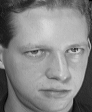

In [6]:
import cv2
from google.colab.patches import cv2_imshow

# Opencv's imread takes full path of an image as input to read an image
im1 = cv2.imread('./data/faces/training/s1/10.pgm')
print(im1.shape)
cv2_imshow(im1)

#### **Define a custom SiameseNetworkDataset class**

This dataset generates a pair of images. 0 for geniune pair (similar) and 1 for imposter pair (dissimilar)

In [7]:
# Below is the class of custom dataset which arranges images in pairs and gives the labels. if both are same, then label will be 0 otherwise 1 
# As our images are in .pgm extension (portable gray map) we converting them 'L' to store luminance which is basically single channel image.

class SiameseNetworkDataset(Dataset):    
    def __init__(self,imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
    
    # Overriding the data retriever (__getitem__) to provide a pair of images + similar/dissimilar label
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

**Create an Image Folder Dataset**

In [8]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

**Create the Siamese Network Dataset**

In [9]:
# Create the object for the SiameseNetworkDataset class (defined earlier in this notebook); 

# NOTE: the 'TRANSFORMS' HERE CONSISTS OF 
# a) resizing to 100*100 
# b) Converting to tensor.

# YOU HAVE TO APPLY THE SAME TRANSORMS WHEN DEPLOYING THE MODEL ON THE SERVER!! 

siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset, transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

**Exclude malformed images to avoid image loading errors** (Use Nonechucks)

In [10]:
# In cases where your dataloader gives 'image not found' error i.e.
# if an image is malformed, nonechucks helps in eliminating those images so that your dataloader doesn't fail.
# So good practice to use this code below

!pip install Nonechucks
import nonechucks as nc

  Created wheel for Nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11549 sha256=2c3538c5ba1cf609628a440cd91f3ce8b9360cd6bbb24aca866008480f68bf44
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built Nonechucks


In [11]:
## The below line will avoid loading the image files that are corrupted or unreadable.
siamese_dataset = nc.SafeDataset(siamese_dataset)

**Visualising some of the data**
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

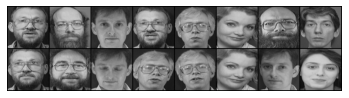

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [12]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

#### **Neural Net Definition**

We will use a standard convolutional neural network

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),       #Pads the input tensor using the reflection of the input boundary, it similar to the padding.
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))
        
    # forward_once is for one image. This can be used while classifying the face images
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
   
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

**Contrastive Loss**

In [14]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

**Training the model**

In [15]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)

In [16]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [17]:
counter = []
loss_history = []
iteration_number= 0

In [18]:
%%capture
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

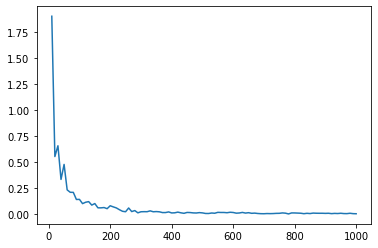

In [19]:
# Plotting the loss graph using the function show_plot
show_plot(counter,loss_history)

**Saving and loading model**

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [20]:
## Saving the model as a state dictionary
state = {'net_dict': net.state_dict()}
torch.save(state, './siamese_model.t7')

**Verifying the saved model with load_state_dict**

In [21]:
myModel = SiameseNetwork().cuda()

In [22]:
%ls

data/  data-20190607T005435Z-001.zip  sample_data/  siamese_model.t7


In [23]:
ckpt = torch.load('./siamese_model.t7')

In [24]:
# Save the state dictionary of the Siamese network (use pytorch only), It will be useful in integrating to the mobile app
# A state_dict is simply a Python dictionary object that maps each layer of the network to its parameters (weights)
# As a Python dictionary it can be easily saved, updated, altered and restored, adding a great deal of modularity to PyTorch models 

myModel.load_state_dict(ckpt['net_dict'])

##### Create the siamese dataset for the `testing_dir` and also the respective data loader. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found the images more similar, while higher values indicate it found them to be dissimilar.

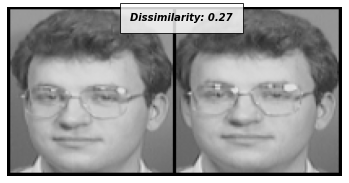

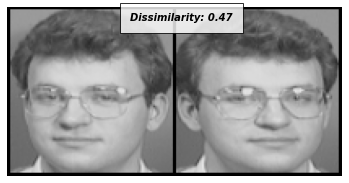

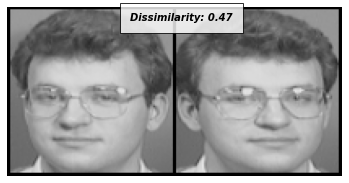

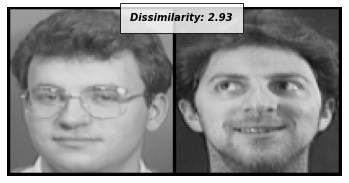

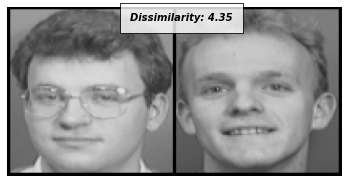

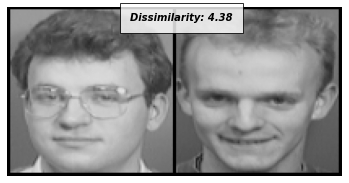

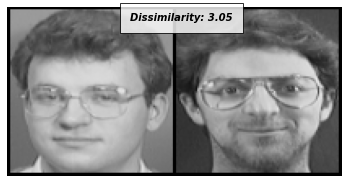

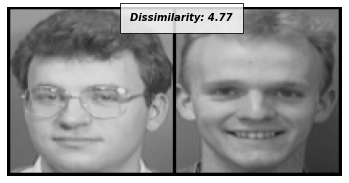

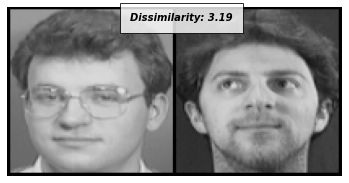

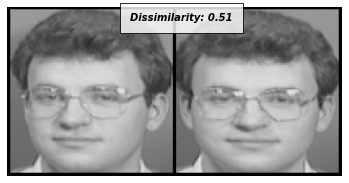

In [25]:
folder_dataset_test = dset.ImageFolder(root = Config.testing_dir) #testing_dir
siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset_test,
                                        transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

siamese_dataset = nc.SafeDataset(siamese_dataset)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

# Check the similarity for the first few images from the test data loader
for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

##**Stage 2: Test for Face Similarity on Mobile App (10 Marks)** 


---




1. Server login and activation steps:

    - A username and password will be provided to your team on the day of the Hackathon.

    - Open the terminal (Command Prompt)
  
  - Login to SSH by typing ssh (username)@aiml-sandbox1.talentsprint.com. Give the login username which is given to you. Type in the password in the next step. Note that the cursor does not move while typing the password.

   `Eg: ssh b15h3gxx@aiml-sandbox1.talentsprint.com`

    (If it is your first time connecting to the server from this computer, accept the connection by typing "yes".)
    - After logging into SSH, activate your virtual environment using the
command **source venv/bin/activate** and then press enter
    - You can start the server by giving the command **sh runserver.sh** and then press enter.

2. Download the Siamese model and upload it in the ftp server (refer to [Filezilla Installation and Configuration document](https://drive.google.com/file/d/1hnMXcwpCwAz94ljAhtsJdQSfe-JaOD5K/view?usp=sharing)) 


3. Update the Siamese model architecture in the **face_recognition_model.py** file and provide the code in the **'get_similarity()'** function of the **face_recognition.py file**. (See Deployment related files)

4. Test the Siamese model in the Mobile app using its Face Similarity application

  - Capture your pic twice and it will return a number between 0 (similar) and 1 (dissimilar) indicating the similarity measure

##**Stage 3: Build Face Recognition Classification Model with Siamese Representation of Team Data and Test on Mobile App (10 Marks)**


---


- Build a Face Recognition Classification Model on Team data
    - Collect Team data on the EFR app (activate the server first)
    
    - Follow the "Mobile_APP_Documentation" to collect the Faces of your team. These will be stored in the server, for which the login is provided to you. [Mobile_APP_Documentation](https://drive.google.com/file/d/1tpr8_U0Ll_TexN4s-0pmPPg23J7Usok2/view?usp=sharing) 

    - Train a classifier (use any classifier) with the features extracted from the above trained Siamese network, for your Team Data 
    - Save the Classification Model with joblib (if Sklearn classification model is used)

- Deploy on the Server

    - Download the trained models (Siamese model, Classification model) and upload them in the ftp server (refer to [Filezilla Installation and Configuration document](https://drive.google.com/file/d/1hnMXcwpCwAz94ljAhtsJdQSfe-JaOD5K/view?usp=sharing)) 
    - Update the Siamese model architecture in the face_recognition_model.py file (If Required) and the code in the **'get_face_class()'** function of the face_recognition.py file. (See Deployment related files)

- Test the model using the Face Recognition application in the EFR Mobile App


**Download your team data from the EFR app into your colab notebook using the links provided below.**

NOTE: Replace the string "username" with your login username (such as b15h3gxx) in the cell below for face images. 

This data will be useful while training the networks.

In [93]:
!wget -nH --recursive --no-parent --reject 'index.*' https://aiml-sandbox.talentsprint.com/expression_detection/b15h3g12/captured_face_images/ --cut-dirs=3  -P ./captured_face_images

--2021-02-20 05:18:08--  https://aiml-sandbox.talentsprint.com/expression_detection/b15h3g12/captured_face_images/
Resolving aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)... 139.162.203.12
Connecting to aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)|139.162.203.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./captured_face_images/index.html.tmp’

index.html.tmp          [ <=>                ]     822  --.-KB/s    in 0s      

2021-02-20 05:18:09 (96.1 MB/s) - ‘./captured_face_images/index.html.tmp’ saved [822]

Loading robots.txt; please ignore errors.
--2021-02-20 05:18:09--  https://aiml-sandbox.talentsprint.com/robots.txt
Reusing existing connection to aiml-sandbox.talentsprint.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-02-20 05:18:09 ERROR 404: Not Found.

Removing ./captured_face_images/index.html.tmp since it should be rejected.

--2021-02-20 05:18:09--  https

In [94]:
# Here simple ImageFolder is enough; we don't need SiameseDataSet 
finalClassifierDset = dset.ImageFolder(root='./captured_face_images',
                                       transform = transforms.Compose([transforms.Grayscale(num_output_channels = 1), transforms.Resize((100,100)), transforms.ToTensor()]))

In [95]:
# Dataloader using the dataset created above.
representation_dataloader = DataLoader(finalClassifierDset, shuffle=False, num_workers=8, batch_size=100)

In [96]:
# Load the state dict of the siamese model 
# <YOUR CODE HERE>
feature_checkpoint = torch.load('/content/siamese_model.t7')
myModel.load_state_dict(feature_checkpoint['net_dict'])
myModel.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [42]:
# Get a siamese representation of each of your data points i.e. for each of your team images.
## For example (if your image is of the size 100*100 above)
# <YOUR CODE HERE>
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset = finalClassifierDset, transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

TypeError: ignored

**Train a Classifier for Face Recognition**

You can use any classifier with the features extracted from the above trained Siamese network of your team data. If required, you have to convert torch variable to numpy array before using SkLearn.

In [97]:
# YOUR CODE HERE for training a classifier. You can use simple MLP or Sklearn models. 
# Note: Ensure you convert torch variable to numpy array before using SkLearn.
classifier = nn.Sequential(nn.Linear(5, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, 4))

classifier =  classifier.cuda()
print(classifier)

Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=4, bias=True)
)


In [98]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(),lr=0.01)

In [65]:
!pip install progress_bar

  Created wheel for progress-bar: filename=progress_bar-8-cp36-none-any.whl size=5588 sha256=817c9f0d509306f5da3240d78e5c55980e59bd4edd65bd7707897bc7a839c001
  Stored in directory: /root/.cache/pip/wheels/04/7e/72/b2261521999fc5bc4ca704b6d84722270d478643c366c6594e
Successfully built progress-bar


In [68]:
import progress_bar

In [99]:
train_loss_file = open('./train_loss_file.txt', mode='w')

In [110]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    classifier.train()
    train_loss = 0
    correct = 0
    total = 1
    for batch_idx, (inputs, targets) in enumerate(representation_dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        features_1 = net.forward_once(inputs)
        print(features_1.shape)
        outputs = classifier(features_1)
        
        loss_step = loss(outputs, targets)   # Compute the contrastive loss, computes the similarity between the features.
        loss_step.backward()
        optimizer.step()

        train_loss += loss_step.item()
        print(batch_idx, len(representation_dataloader), 'Loss: %.3f '% (train_loss/(batch_idx+1)))
    
    train_loss_file.write('%d %.3f\n' %(epoch, train_loss/len(representation_dataloader)))

In [111]:
for epoch in range(0, 20):
    train(epoch)


Epoch: 0
torch.Size([14, 5])
0 1 Loss: 0.004 

Epoch: 1
torch.Size([14, 5])
0 1 Loss: 0.004 

Epoch: 2
torch.Size([14, 5])
0 1 Loss: 0.004 

Epoch: 3
torch.Size([14, 5])
0 1 Loss: 0.004 

Epoch: 4
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 5
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 6
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 7
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 8
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 9
torch.Size([14, 5])
0 1 Loss: 0.003 

Epoch: 10
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 11
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 12
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 13
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 14
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 15
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 16
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 17
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 18
torch.Size([14, 5])
0 1 Loss: 0.002 

Epoch: 19
torch.Size([14, 5])
0 1 Loss: 0.002 


**Save your classification model**

* Save your sklearn models using joblib



In [108]:
# YOUR CODE HERE for saving the model. 
# Note: For SkLearn classifier use joblib for saving the model.
state_classifier = {'net_dict': classifier.state_dict()}
torch.save(state_classifier, './classifier_model.t7')

**Download your trained model using the code below**
* Given the path of model file the following code downloads it through the browser

In [109]:
from google.colab import files
files.download('./classifier_model.t7')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>